# Redoing Bedny (2019) analysis, comparing to word embeddings

## Load ppt data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import numpy as np

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [89]:
df_participant_judgments = pd.read_csv("data/datalong_CBSAMT.csv")

In [90]:
df_participant_judgments.head(5)

,C1,C2,S1,S2,Category,V1,V2,S_01,S_02,S_03,...,CB_31,CB_32,CB_33,CB_34,CB_35,CB_37,CB_38,CB_40,CB_41,AMT_av
0,Sound,Sound,Sanim,Sinanim,Emission,bark,beep,1,3,4,...,1,1.0,1.0,1.0,2.0,1.0,2,1.0,2.0,2.351351
1,Sound,Sound,Sanim,Sanim,Emission,bark,bellow,1,5,5,...,1,4.0,4.0,7.0,4.0,4.0,3,1.0,5.0,4.705882
2,Sound,Light,Sanim,Light,Emission,bark,blaze,1,1,1,...,1,1.0,1.0,6.0,1.0,1.0,1,1.0,5.0,2.184211
3,Sound,Light,Sanim,Light,Emission,bark,blink,1,1,4,...,1,1.0,1.0,7.0,1.0,1.0,1,1.0,2.0,1.657895
4,Sound,Sound,Sanim,Sinanim,Emission,bark,boom,2,3,4,...,1,1.0,1.0,6.0,1.0,4.0,3,1.0,5.0,4.228571


In [91]:
len(df_participant_judgments)

2806

### Merge with cosine distances for each wordpair

In [92]:
df_analysis = pd.read_csv("data/processed/verb_embedding_distances.csv")
df_analysis.head(5)

,Unnamed: 0,cosine_distance,w1,w2
0,0,0.900461,blaze,blink
1,1,0.780368,blaze,flare
2,2,0.929387,blaze,flash
3,3,0.865661,blaze,flicker
4,4,0.856313,blaze,gleam


In [93]:
def combine_words(row, word1='w1', word2='w2'):
    w1, w2 = row[word1], row[word2]
    return '_'.join(sorted([w1, w2]))

In [94]:
df_participant_judgments['combined_words'] = df_participant_judgments.apply(
    lambda row: combine_words(row, word1='V1', word2='V2'), axis=1)

In [95]:
df_analysis['combined_words'] = df_analysis.apply(lambda row: combine_words(row), axis=1)

In [96]:
df_analysis_subset = df_analysis[df_analysis['combined_words'].isin(list(df_participant_judgments['combined_words']))]

In [97]:
df_merged = pd.merge(df_analysis, df_participant_judgments)
df_merged['same_modality'] = df_merged['C1'] == df_merged['C2']

In [98]:
df_merged.head(5)

,Unnamed: 0,cosine_distance,w1,w2,combined_words,C1,C2,S1,S2,Category,...,CB_32,CB_33,CB_34,CB_35,CB_37,CB_38,CB_40,CB_41,AMT_av,same_modality
0,0,0.900461,blaze,blink,blaze_blink,Light,Light,Light,Light,Emission,...,1.0,3.0,1.0,1.0,1.0,3,1.0,2.0,2.000,True
1,1,0.780368,blaze,flare,blaze_flare,Light,Light,Light,Light,Emission,...,4.0,4.0,7.0,4.0,7.0,5,7.0,6.0,4.725,True
2,2,0.929387,blaze,flash,blaze_flash,Light,Light,Light,Light,Emission,...,5.0,4.0,7.0,3.0,7.0,4,4.0,6.0,4.025,True
3,3,0.865661,blaze,flicker,blaze_flicker,Light,Light,Light,Light,Emission,...,2.0,3.0,1.0,1.0,7.0,3,3.0,3.0,3.750,True
4,4,0.856313,blaze,gleam,blaze_gleam,Light,Light,Light,Light,Emission,...,2.0,3.0,4.0,1.0,7.0,5,5.0,4.0,3.225,True


In [99]:
df_merged.to_csv("data/processed/judgments_with_embeddings.csv")

## Do cosine distances predict average similarity judgments?

Here, we want to ask whether the cosine distance between two words in vector-space predicts how similar those words will be judged to be.

Specifically, we are interested in whether the predictive power of **cosine distance**––taken as a proxy for "distributional properties of language"––is differentially successful across modalities, across different groups. For example, one might expect that distributional properties better capture similarity judgments of **amodal** verbs overall, simply because that information is likely to come through language, rather than through embodied, grounded experience (Lupyan and Winter, 2018). Additionally, one might expect that distributional properties play a bigger role in **blind** participants' representations of **vision verbs** than sighted participants, because blind participants do not have direct access to that modality.

In [100]:
import statsmodels.formula.api as sm

### Get data into shape

In [101]:
df_merged = pd.read_csv("data/processed/judgments_with_embeddings.csv")

In [102]:
sighted_columns = ['S_01', 'S_02', 'S_03', 'S_04', 'S_05', 'S_07',
       'S_08', 'S_09', 'S_10', 'S_11', 'S_12', 'S_13', 'S_14', 'S_16', 'S_17',
       'S_18', 'S_19', 'S_20', 'S_21', 'S_22', 'S_23', 'S_24']
blind_columns = ['CB_06',
       'CB_08', 'CB_09', 'CB_14', 'CB_15', 'CB_18', 'CB_19', 'CB_22', 'CB_23',
       'CB_24', 'CB_25', 'CB_26', 'CB_27', 'CB_28', 'CB_29', 'CB_30', 'CB_31',
       'CB_32', 'CB_33', 'CB_34', 'CB_35', 'CB_37', 'CB_38', 'CB_40', 'CB_41']

In [103]:
def get_group_average(row, columns):
    row = row.fillna(0)
    row_col = row[columns].values
    # row_col = [i for i in row_col if i >0 ]
    return row_col.mean()

In [104]:
df_merged['blind_avg'] = df_merged.apply(lambda x: get_group_average(x, columns=blind_columns), 
                                         axis=1)

In [105]:
df_merged['sighted_avg'] = df_merged.apply(lambda x: get_group_average(x, columns=sighted_columns), 
                                         axis=1)

In [106]:
modalities = {'Light': 'Vision',
             'Sound': 'Sound',
             'Touch': 'Touch',
             'Amodal': 'Amodal',
              'Motion': 'Motion',
              'Sight': 'Vision'}

df_merged['Cat1'] = df_merged['C1'].apply(lambda x: modalities[x])
df_merged['Cat2'] = df_merged['C2'].apply(lambda x: modalities[x])

### Get overall R^2 for each group, for each modality

In [132]:
df_same = df_merged[df_merged['same_modality']==True]

In [158]:
modality_to_r2 = []

# for modality in ['Vision', 'Sound', 'Touch', 'Amodal', 'Motion']:
#    df_reduced = df_same[df_same['Cat1']==modality]
    
for modality in set(df_merged['S1']):
    df_reduced = df_same[df_same['S1']==modality]
    
    print(modality)
    print(len(df_reduced))
    
    result_mturk = sm.ols(formula="AMT_av ~ cosine_distance", data=df_reduced).fit()
    result_blind = sm.ols(formula="blind_avg ~ cosine_distance", data=df_reduced).fit()
    result_sighted = sm.ols(formula="sighted_avg ~ cosine_distance", data=df_reduced).fit()
    
    modality_to_r2.append({
        'r2': result_mturk.rsquared_adj,
        'coef': result_mturk.params['cosine_distance'],
        'sem': result_mturk.bse['cosine_distance'],
        'ppt': 'mturk',
        'modality': modality
    })
    modality_to_r2.append({
        'r2': result_blind.rsquared_adj,
        'coef': result_blind.params['cosine_distance'],
        'sem': result_blind.bse['cosine_distance'],
        'ppt': 'blind',
        'modality': modality
    })
    modality_to_r2.append({
        'r2': result_sighted.rsquared_adj,
        'coef': result_sighted.params['cosine_distance'],
        'sem': result_sighted.bse['cosine_distance'],
        'ppt': 'sighted',
        'modality': modality
    })

Light
105
Sinanim
267
Sight
91
Motion
91
Amodal
105
Touch
105
Sanim
168


In [159]:
df_modality_r2 = pd.DataFrame(modality_to_r2)

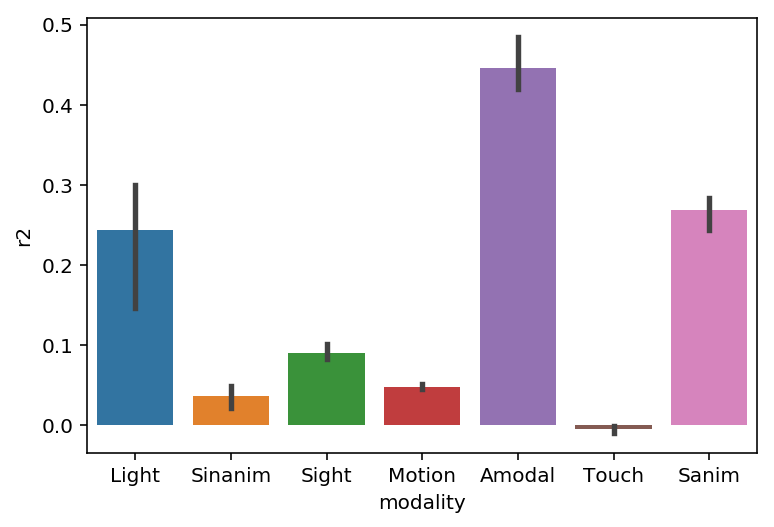

In [160]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2")

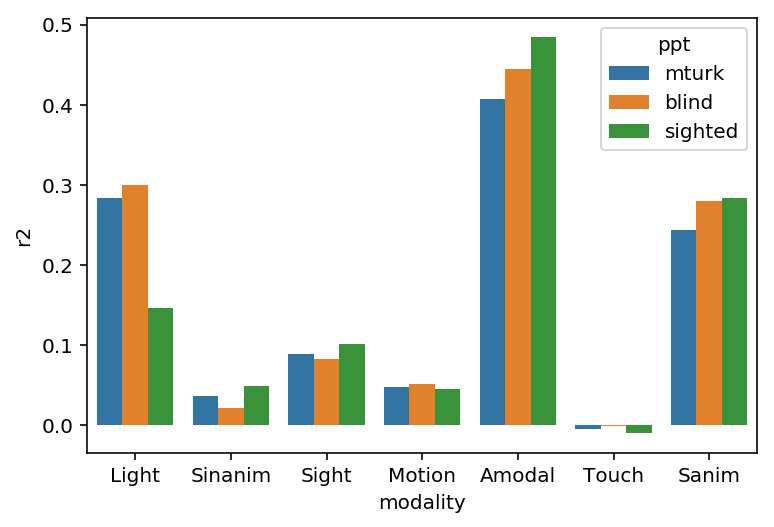

In [161]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2", hue="ppt")

In [162]:
def grouped_barplot(df, cat,subcat, val , err):
    """Just for making barplots with error bars."""
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{} {}".format(subcat, gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.legend()
    plt.show()

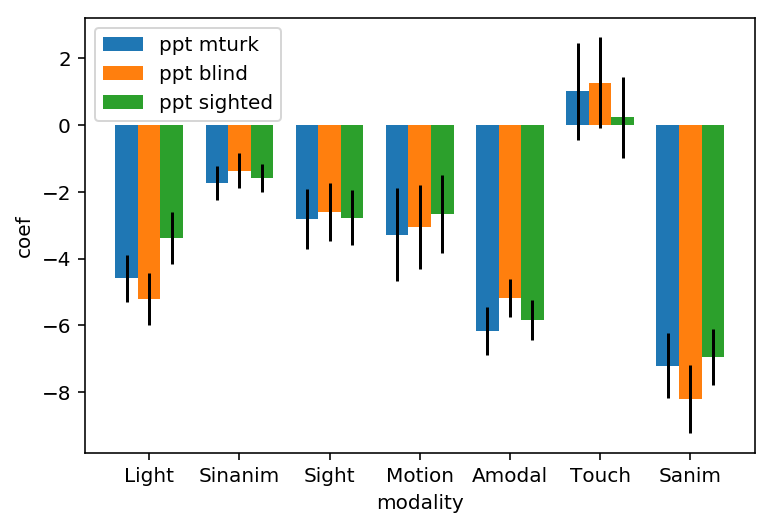

In [163]:
grouped_barplot(df_modality_r2, 'modality', 'ppt', 'coef', 'sem' )

### Compare coefficients for blind vs. sighted, when controlling for MTurk Estimates

Here, we ask whether the observed difference in coefficient size persists once we regress out MTurk estimates of similarity. E.g., does **cosine distance** still have predictive power about the similarity between two verbs even after controlling for other human similarity judgments about those verbs? And does it have *more* predictive power for blind or sighted participants? 

In [166]:
df_same = df_merged[df_merged['same_modality']==True]

In [185]:
modality_to_coef = []

"""
for modality in ['Vision', 'Sound', 'Touch', 'Amodal', 'Motion']:
    df_reduced = df_same[df_same['Cat1']==modality]
"""
for modality in set(df_merged['S1']):
    df_reduced = df_same[df_same['S1']==modality]

    result_blind = sm.ols(formula="blind_avg ~ cosine_distance + AMT_av", data=df_reduced).fit()
    result_sighted = sm.ols(formula="sighted_avg ~ cosine_distance + AMT_av", data=df_reduced).fit()
    modality_to_coef.append({
        'r2': result_blind.rsquared_adj,
        'coef_cosine': result_blind.params['cosine_distance'],
        'coef_mturk': result_blind.params['AMT_av'],
        'sem_cosine': result_blind.bse['cosine_distance'],
        'ppt': 'blind',
        'modality': modality
    })
    modality_to_coef.append({
        'r2': result_sighted.rsquared_adj,
        'coef_cosine': result_sighted.params['cosine_distance'],
        'coef_mturk': result_sighted.params['AMT_av'],
        'sem_cosine': result_sighted.bse['cosine_distance'],
        'ppt': 'sighted',
        'modality': modality
    })

In [186]:
df_modality_coef = pd.DataFrame(modality_to_coef)

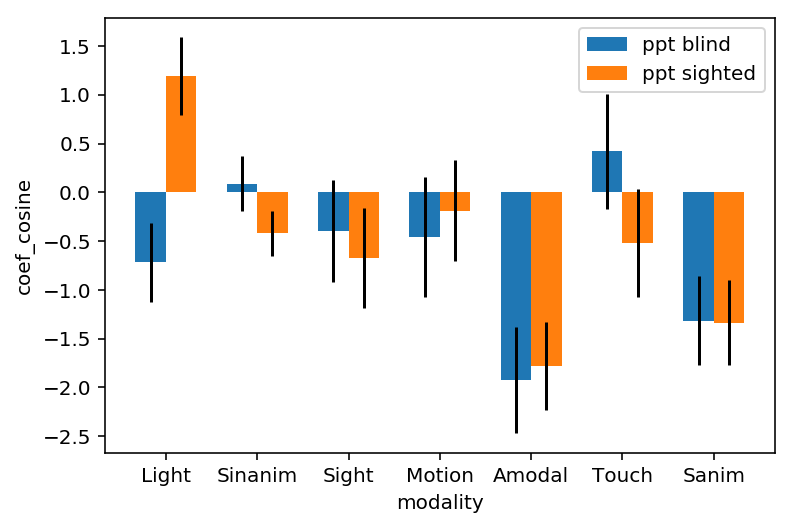

In [187]:
grouped_barplot(df_modality_coef, 'modality', 'ppt', 'coef_cosine', 'sem_cosine' )

### Discussion

The findings are encouraging.

Overall, it appears that **cosine distance** between two words in vector-space carries some information about how similar those words will be judged to be. Of course, this is not a particularly new result. More interesting is the finding that the predictive power of **cosine distance** depends on both **modality** and **participant group**.

#### Modality results 

Distributional properties of words best predict similarity judgmnets for *amodal* verbs (for all participant groups). This is to be expected, as it's believed that a major source of information for *amodal* verbs comes from language itself, rather than grounded meaning.

#### Participant group results

Most compelling is the finding that, even after regressing out *mturk similarity judgments*, **cosine distance** better predicts similarity judgments for *vision verbs* for **blind** than **sighted** participants. This is also in line with our predictions––blind participants are more likely to base their knowledge of verbs for vision on the distributional properties of those verbs.

Interestingly, the coefficient for *vision verbs* for blind participants is equivalently-sized to the coefficient for *amodal verbs* (for both blind and sighted participants).

## Do PCA-reduced embeddings predict MDS and hierarchical clustering?

Here, we use MDS on the vector of similarity judgments for each word, to derive a 4-D set of embeddings to compare to PCA-reduced ELMo embeddings.

Note that we do this separately for perception and emission verbs.

In [220]:
df_verbs = pd.read_csv("data/processed/verbs_with_embeddings.csv")

### Step 1: Multi-dimensional scaling

In [191]:
from sklearn.manifold import MDS

#### Perception verbs

In [261]:
df_perception = df_merged[df_merged['Category']=="Perception"]

In [262]:
words = list(set(list(df_perception['V1']) + list(df_perception['V2'])))
len(words)

44

In [263]:
def get_similarity_judgment(df_similarities, w1, w2, column='blind_avg'):
    """Retrieve average similarity judgment between words."""
    combined = '_'.join(sorted([w1, w2]))
    df_similarities = df_similarities[df_similarities['combined_words']==combined]
    avg_similarity = df_similarities[column].iloc[0]
    # avg_similarity = df_similarities[column].values
    return avg_similarity

In [264]:
len(blind_columns)

25

In [265]:
matrix_blind = np.zeros((len(words),len(words)),dtype=np.int)

for i in range(0,len(words)):
    for j in range(0,len(words)):
        if i != j:
            matrix_blind[i,j] = get_similarity_judgment(df_perception, words[i],words[j], column = "blind_avg")

In [266]:
matrix_sighted = np.zeros((len(words),len(words)),dtype=np.int)

for i in range(0,len(words)):
    for j in range(0,len(words)):
        if i != j:
            matrix_sighted[i,j] = get_similarity_judgment(df_merged, words[i],words[j], column="sighted_avg")

In [267]:
matrix_amt = np.zeros((len(words),len(words)),dtype=np.int)

for i in range(0,len(words)):
    for j in range(0,len(words)):
        if i != j:
            matrix_amt[i,j] = get_similarity_judgment(df_merged, words[i],words[j], column="AMT_av")

In [268]:
embedding = MDS(n_components=2) #, dissimilarity='precomputed')

In [269]:
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)

In [270]:
X_blind_transformed = embedding.fit_transform(matrix_blind)
X_sighted_transformed = embedding.fit_transform(matrix_sighted)
X_amt_transformed = embedding.fit_transform(matrix_amt)

In [271]:
X_all = np.concatenate((X_blind_transformed, X_sighted_transformed, X_amt_transformed), axis=1)
len(X_all)

44

In [272]:
df_mds_perception = pd.DataFrame(X_all, columns = ['d1_blind', 'd2_blind',
                                                  'd1_sighted', 'd2_sighted',
                                                  'd1_amt', 'd2_amt'])

In [273]:
df_mds_perception['verb'] = words

In [274]:
df_mds_perception = pd.merge(df_mds_perception, df_verbs, on="verb")

Text(0.5, 1.0, 'MDS (Sighted) for Perception verbs')

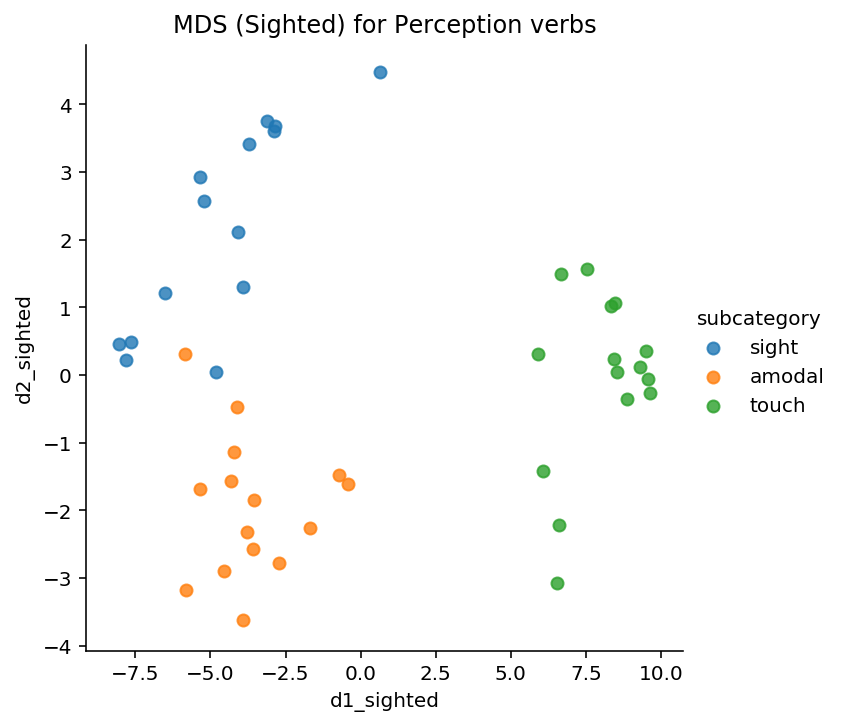

In [275]:
sns.lmplot(x="d1_sighted", y="d2_sighted", data=df_mds_perception, 
           fit_reg=False, hue='subcategory',
           legend=True)
plt.title("MDS (Sighted) for Perception verbs")

Text(0.5, 1.0, 'MDS (blind) for Perception verbs')

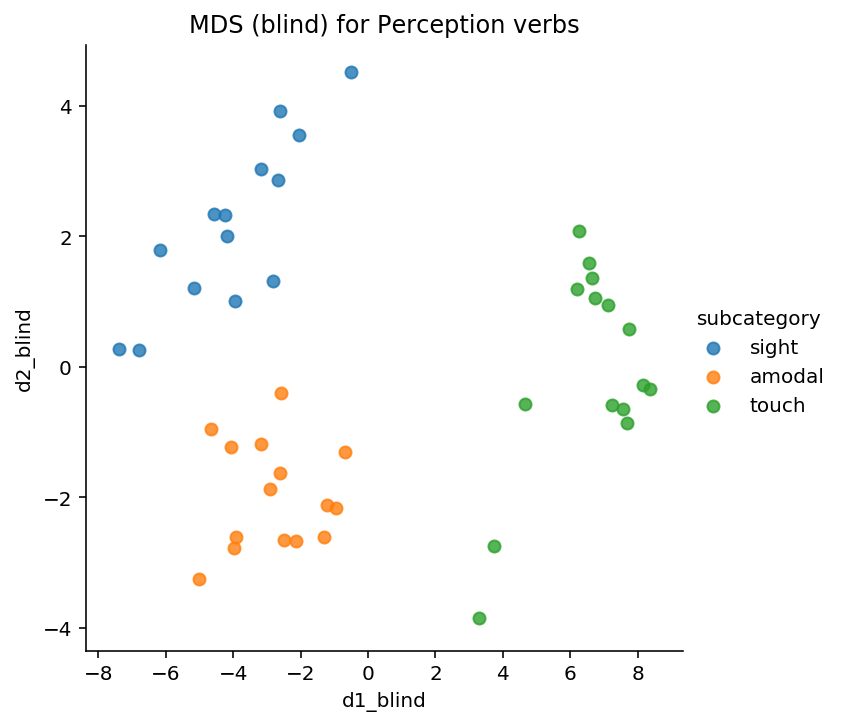

In [276]:
sns.lmplot(x="d1_blind", y="d2_blind", data=df_mds_perception, 
           fit_reg=False, hue='subcategory',
           legend=True)
plt.title("MDS (blind) for Perception verbs")

#### Emission verbs

In [277]:
df_emission = df_merged[df_merged['Category']=="Emission"]

In [278]:
words = list(set(list(df_emission['V1']) + list(df_emission['V2'])))
len(words)

45

In [279]:
matrix_blind = np.zeros((len(words),len(words)),dtype=np.int)

for i in range(0,len(words)):
    for j in range(0,len(words)):
        if i != j:
            matrix_blind[i,j] = get_similarity_judgment(df_merged, words[i],words[j], column="blind_avg")

In [280]:
matrix_sighted = np.zeros((len(words),len(words)),dtype=np.int)

for i in range(0,len(words)):
    for j in range(0,len(words)):
        if i != j:
            matrix_sighted[i,j] = get_similarity_judgment(df_merged, words[i],words[j], column="sighted_avg")

In [281]:
matrix_amt = np.zeros((len(words),len(words)),dtype=np.int)

for i in range(0,len(words)):
    for j in range(0,len(words)):
        if i != j:
            matrix_amt[i,j] = get_similarity_judgment(df_merged, words[i],words[j], column="AMT_av")

In [282]:
embedding = MDS(n_components=2)

In [283]:
from sklearn.decomposition import PCA
embedding = PCA(n_components=2)

In [284]:
X_blind_transformed = embedding.fit_transform(matrix_blind)
X_sighted_transformed = embedding.fit_transform(matrix_sighted)
X_amt_transformed = embedding.fit_transform(matrix_amt)

In [285]:
X_all = np.concatenate((X_blind_transformed, X_sighted_transformed, X_amt_transformed), axis=1)
len(X_all)

45

In [286]:
df_mds_emission = pd.DataFrame(X_all, columns = ['d1_blind', 'd2_blind',
                                                  'd1_sighted', 'd2_sighted',
                                                  'd1_amt', 'd2_amt'])

In [287]:
df_mds_emission['verb'] = words

In [288]:
df_mds_emission = pd.merge(df_mds_emission, df_verbs, on="verb")

Text(0.5, 1.0, 'MDS (Sighted) for Emission verbs')

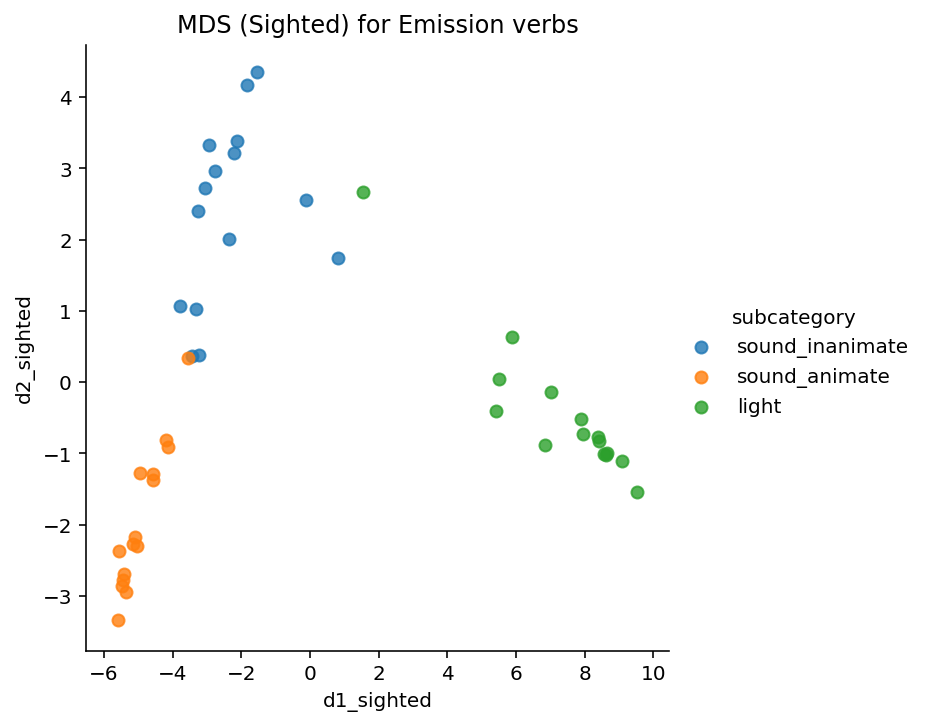

In [289]:
sns.lmplot(x="d1_sighted", y="d2_sighted", data=df_mds_emission, 
           fit_reg=False, hue='subcategory',
           legend=True)
plt.title("MDS (Sighted) for Emission verbs")

Text(0.5, 1.0, 'MDS (blind) for Emission verbs')

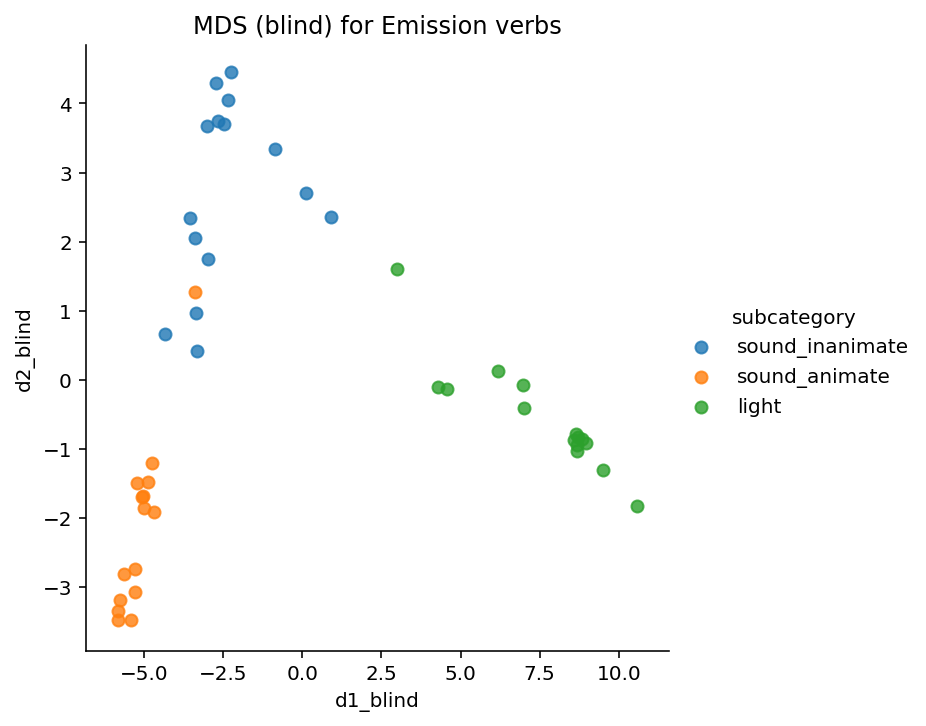

In [290]:
sns.lmplot(x="d1_blind", y="d2_blind", data=df_mds_emission, 
           fit_reg=False, hue='subcategory',
           legend=True)
plt.title("MDS (blind) for Emission verbs")

### Step 2: Predict MDS scaling with word embeddings

In [291]:
from sklearn import linear_model

#### Perception verbs

In [292]:
modality_to_r2 = []

for modality in set(df_mds_perception['subcategory']):
    df_reduced = df_mds_perception[df_mds_perception['subcategory']==modality]
    
    y_blind = df_reduced[['d1_blind', 'd2_blind']].values
    y_sighted = df_reduced[['d1_sighted', 'd2_sighted']].values
    y_amt = df_reduced[['d1_amt', 'd2_amt']].values

    X = df_reduced[['pc1', 'pc2']].values
    
    lm = linear_model.LinearRegression()
    model_blind = lm.fit(X,y_blind)
    score_blind = model_blind.score(X, y_blind)
    
    lm = linear_model.LinearRegression()
    model_sighted = lm.fit(X,y_sighted)
    score_sighted = model_sighted.score(X, y_sighted)

    lm = linear_model.LinearRegression()
    model_amt = lm.fit(X,y_amt)
    score_amt = model_amt.score(X, y_amt)
    
    modality_to_r2.append({
        'r2': score_blind,
        'ppt': 'blind',
        'modality': modality
    })
    
    modality_to_r2.append({
        'r2': score_sighted,
        'ppt': 'sighted',
        'modality': modality
    })
    modality_to_r2.append({
        'r2': score_amt,
        'ppt': 'amt',
        'modality': modality
    })

In [293]:
df_modality_r2 = pd.DataFrame(modality_to_r2)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


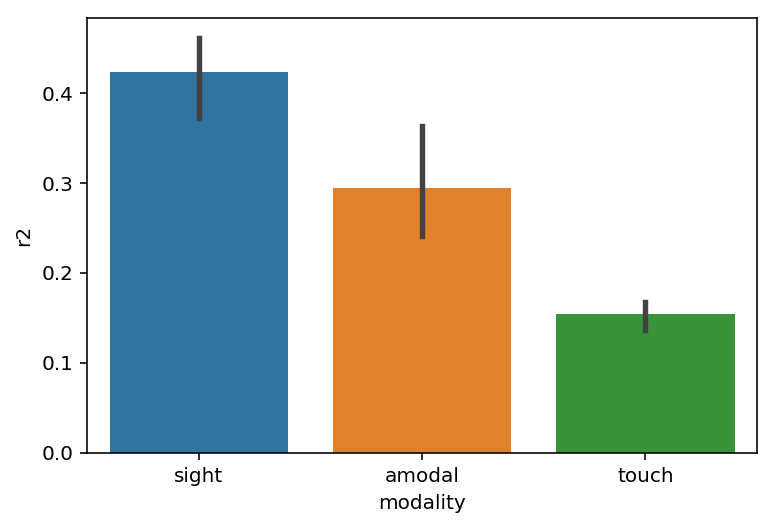

In [294]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2")

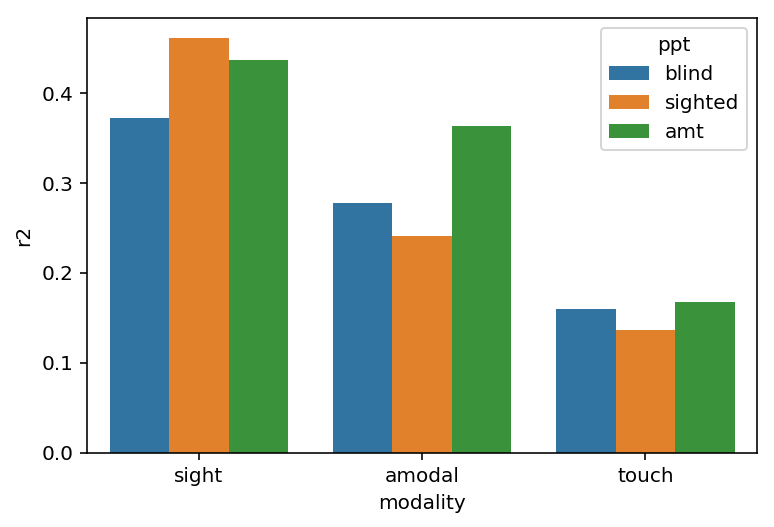

In [295]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2", hue='ppt')

#### Emission verbs

In [296]:
modality_to_r2 = []

for modality in set(df_mds_emission['subcategory']):
    df_reduced = df_mds_emission[df_mds_emission['subcategory']==modality]
    
    y_blind = df_reduced[['d1_blind', 'd2_blind']].values
    y_sighted = df_reduced[['d1_sighted', 'd2_sighted']].values
    y_amt = df_reduced[['d1_amt', 'd2_amt']].values
    
    X = df_reduced[['pc1', 'pc2']].values
    
    lm = linear_model.LinearRegression()
    model_blind = lm.fit(X,y_blind)
    score_blind = model_blind.score(X, y_blind)
    
    lm = linear_model.LinearRegression()
    model_sighted = lm.fit(X,y_sighted)
    score_sighted = model_sighted.score(X, y_sighted)

    lm = linear_model.LinearRegression()
    model_amt = lm.fit(X,y_amt)
    score_amt = model_amt.score(X, y_amt)
    
    modality_to_r2.append({
        'r2': score_blind,
        'ppt': 'blind',
        'modality': modality
    })
    
    modality_to_r2.append({
        'r2': score_sighted,
        'ppt': 'sighted',
        'modality': modality
    })
    modality_to_r2.append({
        'r2': score_amt,
        'ppt': 'amt',
        'modality': modality
    })

In [297]:
df_modality_r2 = pd.DataFrame(modality_to_r2)

/Users/seantrott/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


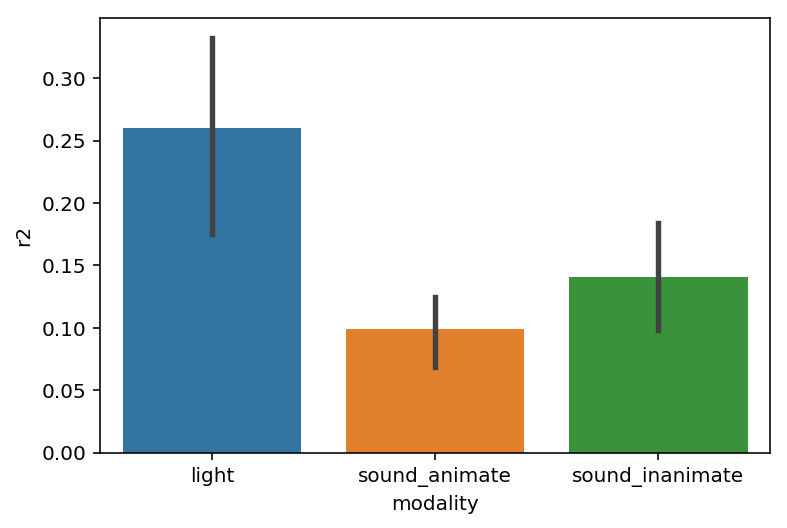

In [298]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2")

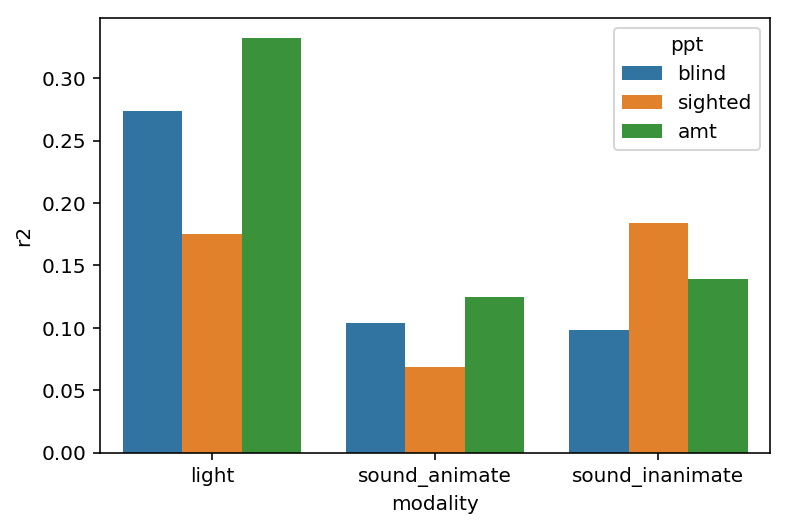

In [299]:
sns.barplot(data = df_modality_r2,
           x = "modality", y ="r2", hue='ppt')

### Step 3: Hierarchical clustering

In [300]:
from scipy.cluster.hierarchy import dendrogram, linkage

### Hierarchical clustering 

#### Perception verbs

In [320]:
df_mds_sight = df_mds_perception[df_mds_perception['subcategory']=="sight"]

In [321]:
X_linked_blind = linkage(df_mds_sight[['d1_blind', 'd2_blind']].values, 'ward')
X_linked_sight = linkage(df_mds_sight[['d1_sighted', 'd2_sighted']].values, 'ward')
X_linked_embedding = linkage(df_mds_sight[['pc1', 'pc2']].values, 'ward')

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [20.0, 20.0, 40.0, 40.0],
  [5.0, 5.0, 30.0, 30.0],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [85.0, 85.0, 95.0, 95.0],
  [62.5, 62.5, 90.0, 90.0],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [110.0, 110.0, 130.0, 130.0],
  [76.25, 76.25, 120.0, 120.0],
  [17.5, 17.5, 98.125, 98.125]],
 'dcoord': [[0.0, 0.5394352588211034, 0.5394352588211034, 0.0],
  [0.0, 0.6890625678514852, 0.6890625678514852, 0.0],
  [0.5394352588211034,
   1.3962642224642319,
   1.3962642224642319,
   0.6890625678514852],
  [0.0, 3.0699881618887956, 3.0699881618887956, 1.3962642224642319],
  [0.0, 0.32746261978890967, 0.32746261978890967, 0.0],
  [0.0, 0.47735435747572896, 0.47735435747572896, 0.32746261978890967],
  [0.0, 1.1462456205714555, 1.1462456205714555, 0.0],
  [0.47735435747572896,
   2.2086765331106712,
   2.2086765331106712,
   1.1462456205714555],
  [0.0, 0.6144042846115972, 0.6144042846115972, 0.0

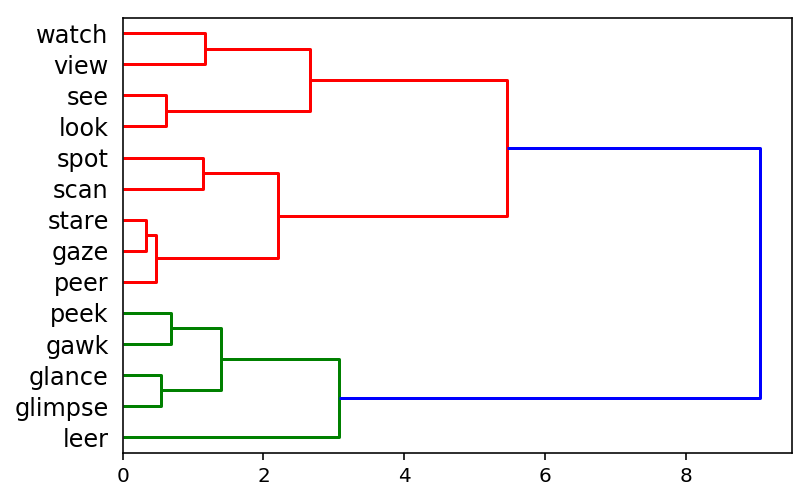

In [322]:
dendrogram(X_linked_blind,  
            orientation='right',
           labels=list(df_mds_sight['verb']),
            distance_sort='descending',
            show_leaf_counts=True)

{'icoord': [[35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [15.0, 15.0, 32.5, 32.5],
  [5.0, 5.0, 23.75, 23.75],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [55.0, 55.0, 72.5, 72.5],
  [95.0, 95.0, 105.0, 105.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [100.0, 100.0, 122.5, 122.5],
  [63.75, 63.75, 111.25, 111.25],
  [14.375, 14.375, 87.5, 87.5]],
 'dcoord': [[0.0, 0.08000516139141485, 0.08000516139141485, 0.0],
  [0.0, 0.32086762563808113, 0.32086762563808113, 0.08000516139141485],
  [0.0, 0.9860028002520809, 0.9860028002520809, 0.32086762563808113],
  [0.0, 4.914225481531758, 4.914225481531758, 0.9860028002520809],
  [0.0, 0.31692753886383607, 0.31692753886383607, 0.0],
  [0.0, 0.3974646085307565, 0.3974646085307565, 0.31692753886383607],
  [0.0, 1.9177752299404627, 1.9177752299404627, 0.3974646085307565],
  [0.0, 0.3779718730901374, 0.3779718730901374, 0.0],
  [0.0, 0.8205340359085976, 0.8205340359085976, 0.0],
  [0.0, 2.1431089813298

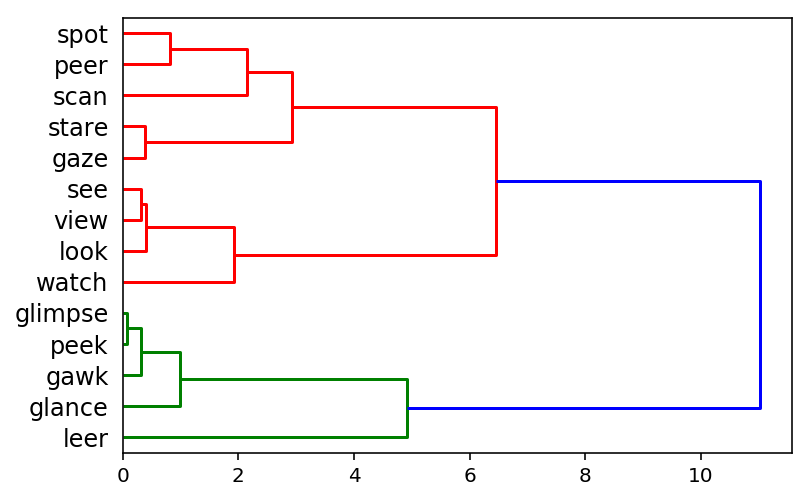

In [323]:
dendrogram(X_linked_sight,  
            orientation='right',
           labels=list(df_mds_sight['verb']),
            distance_sort='descending',
            show_leaf_counts=True)

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5],
  [65.0, 65.0, 75.0, 75.0],
  [55.0, 55.0, 70.0, 70.0],
  [95.0, 95.0, 105.0, 105.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [100.0, 100.0, 122.5, 122.5],
  [85.0, 85.0, 111.25, 111.25],
  [62.5, 62.5, 98.125, 98.125],
  [21.25, 21.25, 80.3125, 80.3125]],
 'dcoord': [[0.0, 0.790509622090115, 0.790509622090115, 0.0],
  [0.0, 0.8489451623642451, 0.8489451623642451, 0.0],
  [0.0, 1.2092663297244148, 1.2092663297244148, 0.8489451623642451],
  [0.790509622090115,
   4.477066989406002,
   4.477066989406002,
   1.2092663297244148],
  [0.0, 1.5976786451501872, 1.5976786451501872, 0.0],
  [0.0, 3.2301070351726153, 3.2301070351726153, 1.5976786451501872],
  [0.0, 1.013440801957138, 1.013440801957138, 0.0],
  [0.0, 1.5057922978591691, 1.5057922978591691, 0.0],
  [0.0, 2.257130283073061, 2.257130283073061, 1.5057922978591691],
  [1.013440801957138, 4.16

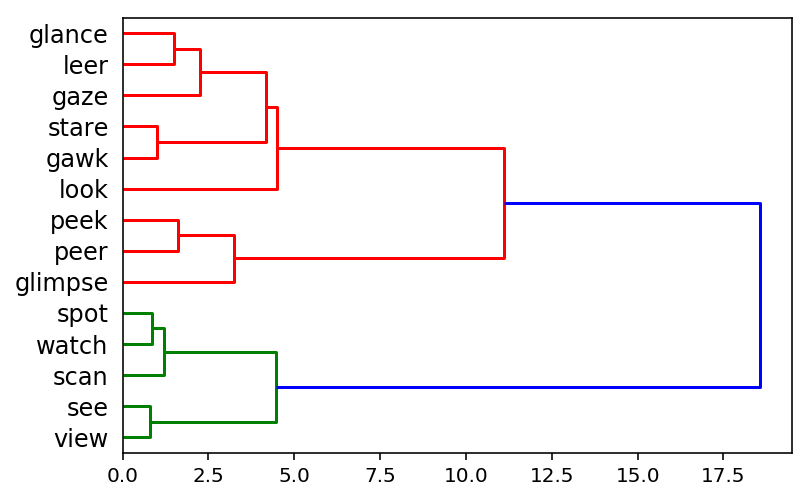

In [324]:
dendrogram(X_linked_embedding,  
            orientation='right',
           labels=list(df_mds_sight['verb']),
            distance_sort='descending',
            show_leaf_counts=True)

In [325]:
lm = linear_model.LinearRegression()
model = lm.fit(X_linked_embedding, X_linked_blind)
model.score(X_linked_embedding, X_linked_blind)

0.8861191126058884

In [326]:
lm = linear_model.LinearRegression()
model = lm.fit(X_linked_embedding, X_linked_sight)
model.score(X_linked_embedding, X_linked_sight)

0.8054488560949233